In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
img_width = 256
img_height = 256
img_channels = 3

# Custom for a specific Problem

## Importing the Libraries

In [4]:
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

## Setting the path

In [5]:
train_path = "D:\\Data sets\\DRIVE\\training"
test_path = "D:\\Data sets\\DRIVE\\test"

In [6]:


train_path = "D:\\Data sets\\DRIVE\\training"
train_ids = next(os.walk(train_path + "\\images"))[2]
gt_ids = next(os.walk(train_path + "\\1st_manual"))[2]

test_ids = next(os.walk(test_path + "\images"))[2]

In [7]:
train_ids[:5], gt_ids[:5], test_ids[:5] 

(['21_training.tif',
  '22_training.tif',
  '23_training.tif',
  '24_training.tif',
  '25_training.tif'],
 ['21_manual1.gif',
  '22_manual1.gif',
  '23_manual1.gif',
  '24_manual1.gif',
  '25_manual1.gif'],
 ['01_test.tif', '02_test.tif', '03_test.tif', '04_test.tif', '05_test.tif'])

## Setting the train and test 

In [8]:
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width), dtype=np.float32)

In [9]:
import gif2numpy
import cv2

In [10]:
from skimage.filters import threshold_otsu
thresh = 0

In [11]:
def gtImageDis(gt_path):
    frames, exts, image_specs = gif2numpy.convert(gt_path)
    frames = np.array(frames)
    labeled_img = frames.reshape(584, 565,3)
    labeled_img_dis = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)
    binary = labeled_img_dis > thresh
    return binary

In [12]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = train_path +"\\images\\" +id_
    img = imread(path,plugin="pil")[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    
    X_train[n] = img  #Fill empty X_train with values from img
            
    gt_path = train_path+ "\\1st_manual\\" + gt_ids[n]
    gt_img = gtImageDis(gt_path)
    
    gt_img = resize(gt_img, (img_height, img_width), mode='constant', preserve_range=True)
    Y_train[n] = gt_img
    
print("Done")

Resizing training images and masks


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]

Done


In [13]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 1197419, 1.0: 113301}

In [14]:
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []

In [15]:
# test images
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path +"\\images\\" +id_
    img = imread(path,plugin="pil")[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)

    X_test[n] = img

print('Done!')

  0%|          | 0/20 [00:00<?, ?it/s]

Resizing test images


100%|██████████| 20/20 [00:01<00:00, 14.55it/s]

Done!


## Preview of the Work Done Till Now

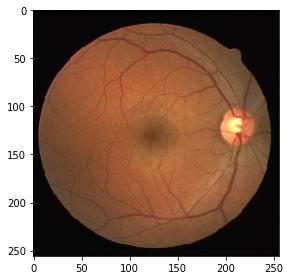

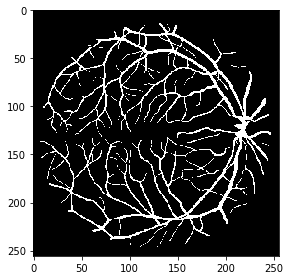

In [16]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# The Model

In [17]:
norm_inputs = tf.keras.layers.Input((img_height, img_width,img_channels))
inputs = tf.keras.layers.Lambda(lambda x: x/255)(norm_inputs)

In [18]:
inputs

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'lambda')>

## Contraction Path

In [19]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

In [20]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

In [21]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

In [22]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

In [23]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c5)
p5 = tf.keras.layers.MaxPool2D((2,2))(c5)

## Expansive Path

In [24]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

In [25]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

In [26]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

In [27]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

## Model Compilation

In [28]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [29]:
from keras import backend as K

In [30]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [31]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred) 

In [32]:
model = tf.keras.Model(inputs=[norm_inputs], outputs=[outputs])
model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Model Check Point

In [33]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("u_net_model.h5", verbose=1, save_best_only=True)

In [34]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [35]:
es = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
tboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

# Results

In [36]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
1/1 [==============================] - 65s 65s/step - loss: -0.0721 - jacard_coef: 0.0721 - val_loss: -0.0833 - val_jacard_coef: 0.0833
Epoch 2/25
1/1 [==============================] - 0s 354ms/step - loss: -0.0884 - jacard_coef: 0.0884 - val_loss: -0.0911 - val_jacard_coef: 0.0911
Epoch 3/25
1/1 [==============================] - 0s 347ms/step - loss: -0.0923 - jacard_coef: 0.0923 - val_loss: -0.0931 - val_jacard_coef: 0.0931
Epoch 4/25
1/1 [==============================] - 0s 365ms/step - loss: -0.0955 - jacard_coef: 0.0955 - val_loss: -0.0943 - val_jacard_coef: 0.0943
Epoch 5/25
1/1 [==============================] - 0s 346ms/step - loss: -0.0979 - jacard_coef: 0.0979 - val_loss: -0.0950 - val_jacard_coef: 0.0950
Epoch 6/25
1/1 [==============================] - 0s 351ms/step - loss: -0.0989 - jacard_coef: 0.0989 - val_loss: -0.0956 - val_jacard_coef: 0.0956
Epoch 7/25
1/1 [==============================] - 0s 345ms/step - loss: -0.0995 - jacard_coef: 0.0995 - val_loss:

In [37]:
#idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0])], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0).astype(np.uint8)
preds_test_t = (preds_test > 0).astype(np.uint8)

1/1 [==============================] - 0s 17ms/step


## Sanity check on some random training samples

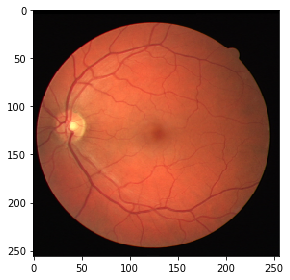

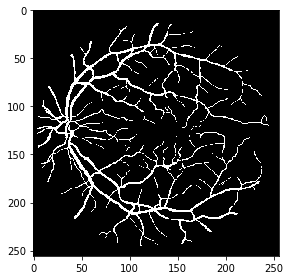

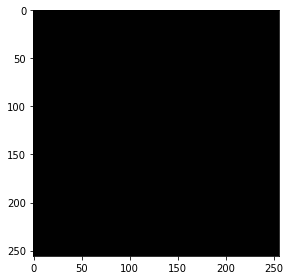

In [38]:

ix = random.randint(0, len(preds_train_t)-1)
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(np.squeeze(preds_train_t[ix]), cmap = "gray")
plt.show()

## Sanity check on some random testing samples

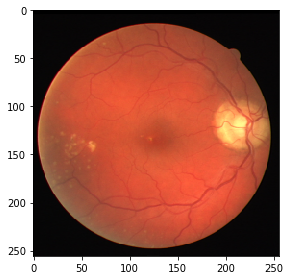

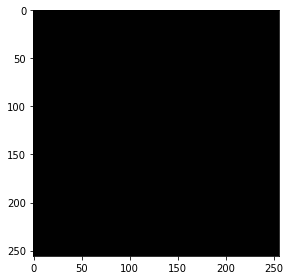

In [39]:
ix = random.randint(0, len(preds_test_t) - 1)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()